In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import abspath, dirname, join
import sys
from glob import glob
import random
import hydra
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from tqdm import tqdm
import torch

root = abspath(join(dirname("__file__"), '../../'))
sys.path.append(root)
from src.data.generator.classification.build import get_training_datasets

import matplotlib.pyplot as plt

# Initializing Hydra
There are several ways to initialize. See the [API docs](https://hydra.cc/docs/next/experimental/compose_api/#api-documentation) for full details.
All methods support both a function call style that changes the global state, and a context style that cleans up when theg scope exits.

## Global initialization
Calling each of the initilizaiton methods outside of a context changes the global state.

In [3]:
config_path = '../../configs'
config_name='test'

In [4]:
model_name = 'person_attribute' #'resnet50_defaults'
model_folder = '20201207_20_21_34' #'20200914_20_41_11'

In [5]:
# clear hyudra instance for running twice
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [6]:
initialize(config_path=config_path)
model_id = '${MODEL_ID}'
cfg = compose(overrides=[f'+experiment={model_name}', f'MODEL_PATH=models/{model_id}/{model_folder}/', 'DATA.DATA_ID=person_attribute','DATA.TRAIN_IMAGE_DIR=data/${DATA.DATA_ID}/raw/images', 'TEST.TEST_IMAGE_DIR=data/${DATA.DATA_ID}/raw/images',
                         'DATA.CSV_PATH=data/${DATA.DATA_ID}/split/train_v1.csv','+augmentation=albumentations_classification', 'data=classification','model=classification/resnet', '+loss=classification', 'test=classification'], config_name=config_name) # 'DATA.PROCESSED_CSV_NAME=_features.csv', 'DATA.EXTRACT_ONE_CLASS=true', 'DATA.FOLD_TARGET_COL=count',
print(cfg)

{'FRAMEWORK': 'pytorch', 'TASK': 'classification', 'MODEL_PATH': 'models/${MODEL_ID}/20201207_20_21_34/', 'TEST_ID': 'test', 'DATA': {'DATA_ID': 'person_attribute', 'NUM_CLASSES': 7, 'TRAIN_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/images', 'CVAT_TASK_TYPE': 'classification', 'EXTRACT_ONE_CLASS': False, 'PROCESSED_CSV_NAME': '_features.csv', 'CSV_PATH': 'data/${DATA.DATA_ID}/split/train_v1.csv', 'RANDOM_KFOLD': False, 'TEST_SIZE': 0.2, 'N_FOLD': 1, 'FORMAT': None, 'IMAGE_ID_COL_NAME': 'image_id', 'FOLD_TARGET_COL': 'attr_name'}, 'DATASET': {'CLASS_NAME': 'src.data.generator.classification.dataset.AttrDataset', 'CUTMIX': False}, 'TEST': {'BATCH_SIZE': 32, 'TEST_IMAGE_DIR': 'data/${DATA.DATA_ID}/raw/images', 'TEST_CSV_PATH': 'data/${DATA.DATA_ID}/split/test_v1.csv', 'VISUALIZE_RESULTS': True, 'VAL_PRED_IMG_DIR': 'pred_images/validation/', 'TEST_PRED_IMG_DIR': 'pred_images/test/', 'SAVE_ALL_IMAGES': False, 'THRESHOLD': 0.5, 'FIND_BEST_THR': False, 'BEST_THR_CSV_NAME': 'best_score_threshold.cs

# Check Augmentations

## Move to Root Directory(./BaseModel)

In [7]:
!pwd

/data1/r_suzuki/pipeline/BaseModel/notebooks/classification


In [8]:
%cd ../../

/data1/r_suzuki/pipeline/BaseModel


## Get Datasets

In [172]:
def get_train_transforms():
    return A.Compose([
              A.Resize(always_apply=False, p=1, height=256, width=192, interpolation=1),
              A.PadIfNeeded(always_apply=False, p=1, min_height=10, min_width=10, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
              A.RandomCrop(always_apply=False, p=1, height=256, width=192),
#               A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
#               A.OneOf([
#                 A.RandomBrightness(always_apply=False, p=1, limit=(-0.1, 0.1)),
#                 A.RandomContrast(always_apply=False, p=1, limit=(-0.1, 0.1)),
#               ], p=0.3),
              A.OneOf([
                A.MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
                A.MedianBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
                A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5), sigma_limit=(0, 0)),
                A.GaussNoise(always_apply=False, p=0.5, var_limit=(5.0, 30.0)),
              ], p=0.5),
              A.Cutout(always_apply=False, p=0.5, num_holes=4, max_h_size=8, max_w_size=8),
              A.HorizontalFlip(always_apply=False, p=0.5),
              A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-15, 15), interpolation=1, border_mode=0, value=None, mask_value=None),
              A.Normalize(always_apply=True, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
              ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
            ]
        , p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}
    )

In [173]:
train_augs = get_train_transforms()

In [174]:
fold = 0
datasets = get_training_datasets(cfg, fold, train_augs=train_augs)
train_dataset = datasets['train']
valid_dataset = datasets['valid']

Train df length: 91667
Val df length: 22917
Framework: albumentations_classification
Train 
 Compose([
  Resize(always_apply=False, p=1, height=256, width=192, interpolation=1),
  PadIfNeeded(always_apply=False, p=1, min_height=10, min_width=10, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
  RandomCrop(always_apply=False, p=1, height=256, width=192),
  OneOf([
    MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
    MedianBlur(always_apply=False, p=0.5, blur_limit=(3, 5)),
    GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 5), sigma_limit=(0, 0)),
    GaussNoise(always_apply=False, p=0.5, var_limit=(5.0, 30.0)),
  ], p=0.5),
  Cutout(always_apply=False, p=0.5, num_holes=4, max_h_size=8, max_w_size=8),
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_li

## Plot a Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 192, 3)


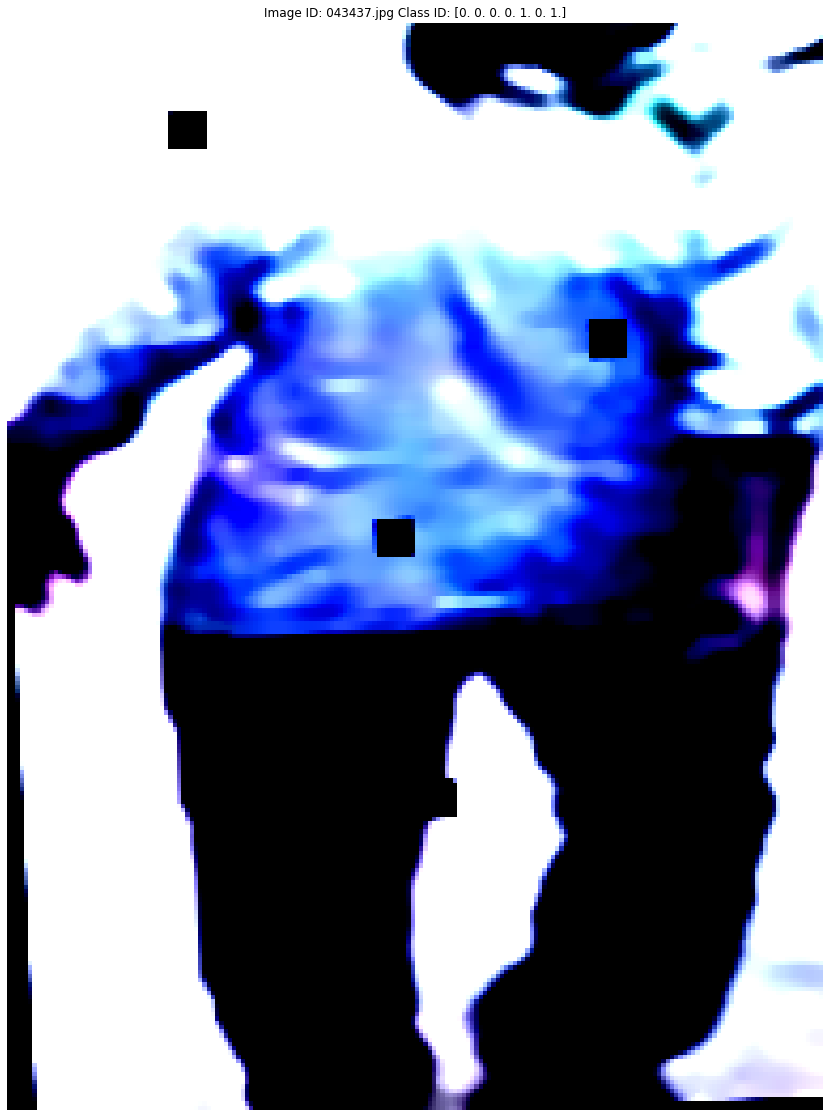

In [177]:
idx = 4
image, target, image_id = train_dataset.__getitem__(idx)

fig, ax = plt.subplots(1, 1, figsize=(15, 20))
# img = image.permute(2, 1, 0)
# img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
img = image.to('cpu').detach().numpy().copy()
img = img.transpose(1,2,0) #1,2,0
print(img.shape)
ax.set_axis_off()
ax.set_title(f'Image ID: {image_id} Class ID: {target}')
ax.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


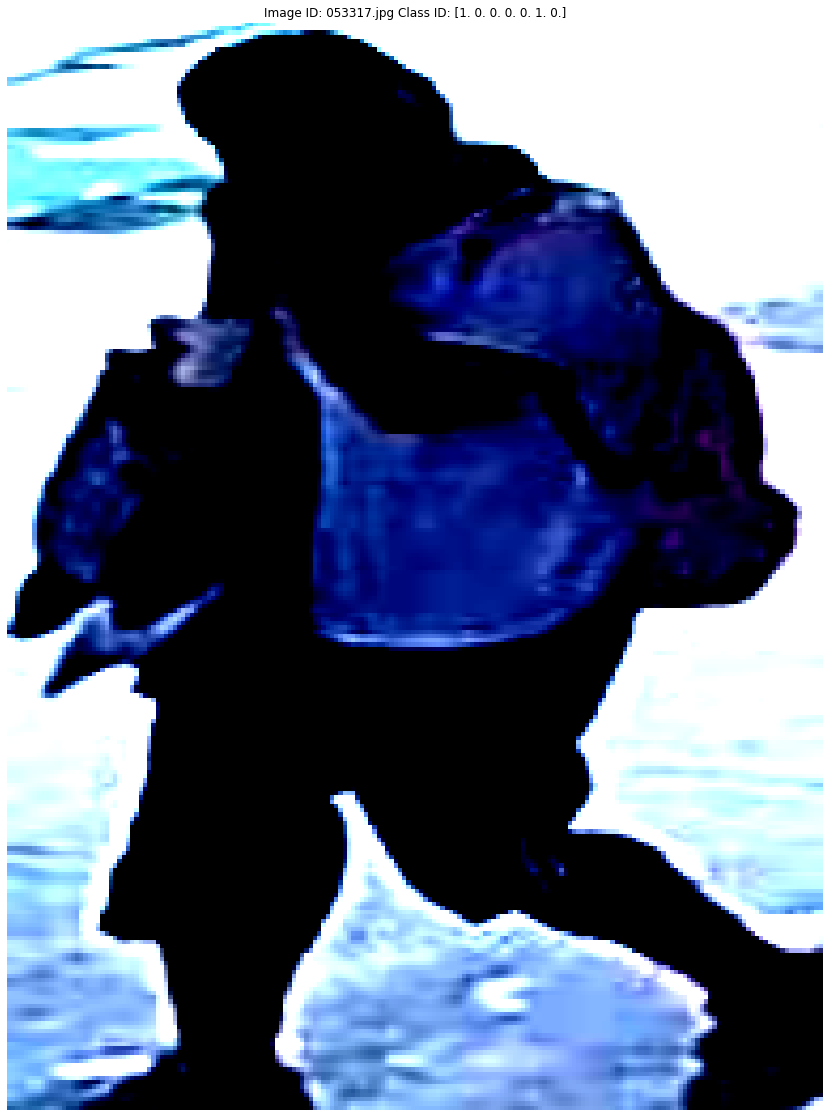

In [126]:
idx = 5
image, target, image_id = valid_dataset.__getitem__(idx)

fig, ax = plt.subplots(1, 1, figsize=(15, 20))
img = image.to('cpu').detach().numpy().copy()
img = img.transpose(1,2,0)
    
ax.set_axis_off()
ax.set_title(f'Image ID: {image_id} Class ID: {target}')
ax.imshow(img)

# Make Augmentations using Albumentations

[Albumentations Github Page](https://github.com/albumentations-team/albumentations)

## How to save and load parameters of an augmentation pipeline


[Official Document](https://albumentations.ai/docs/examples/serialization/)

### Define an augmentation pipeline that we want to serialize

In [ ]:
def get_train_transforms():
	return A.Compose(
            [
#                 A.RandomSizedCrop(min_max_height=(800, 1024), height=1024, width=1024, p=0.5),
                A.OneOf([
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
                ],p=0.9),
                A.ToGray(p=0.01),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Transpose(p=0.5),
#                 A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
                A.OneOf([
                    A.Blur(blur_limit=3, p=1.0),
                    A.MedianBlur(blur_limit=3, p=1.0)
                    ],p=0.1),
                A.Resize(height=1024, width=1024, p=1),
                A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
                ToTensorV2(p=1.0),
            ], p=1.0,
            bbox_params=A.BboxParams(
                format='pascal_voc',
                min_area=0,
                min_visibility=0,
                label_fields=['labels']
                )
            )

In [ ]:
train_augs = get_train_transforms()

In [108]:
type(train_augs)

albumentations.core.composition.Compose

In [ ]:
!pwd

### Save Augmentations as yaml file

In [ ]:
A.core.serialization.save(train_augs, './configs/augmentation/train_aug_tutorial.yaml', data_format='yaml')

### Load Augmentations from yaml file

In [ ]:
train_augs_loaded = A.load('./configs/augmentation/train_aug_tutorial.yaml', data_format='yaml')

In [ ]:
train_augs_loaded

### Delete example yaml file

In [ ]:
!ls ./configs/augmentation/train_aug_tutorial.yaml

In [ ]:
!rm ./configs/augmentation/train_aug_tutorial.yaml

In [ ]:
!ls ./configs/augmentation/train_aug_tutorial.yaml